Creating animations...
Global alignment animation saved as 'global_alignment.gif'
Global alignment animation saved as 'global_alignment.gif'
Local alignment animation saved as 'local_alignment.gif'
Local alignment animation saved as 'local_alignment.gif'
Viterbi animation saved as 'viterbi.gif'
Viterbi animation saved as 'viterbi.gif'
De Bruijn graph animation saved as 'debruijn.gif'
De Bruijn graph animation saved as 'debruijn.gif'
Overlap graph animation saved as 'overlap.gif'
Overlap graph animation saved as 'overlap.gif'


Creating animations...
Global alignment animation saved as 'global_alignment.gif'
Global alignment animation saved as 'global_alignment.gif'
Local alignment animation saved as 'local_alignment.gif'
Local alignment animation saved as 'local_alignment.gif'
Viterbi animation saved as 'viterbi.gif'
Viterbi animation saved as 'viterbi.gif'
De Bruijn graph animation saved as 'debruijn.gif'
De Bruijn graph animation saved as 'debruijn.gif'
Overlap graph animation saved as 'overlap.gif'
Overlap graph animation saved as 'overlap.gif'


IndexError: string index out of range

Creating animations...
Global alignment animation saved as 'global_alignment.gif'
Global alignment animation saved as 'global_alignment.gif'
Local alignment animation saved as 'local_alignment.gif'
Local alignment animation saved as 'local_alignment.gif'
Viterbi animation saved as 'viterbi.gif'
Viterbi animation saved as 'viterbi.gif'
De Bruijn graph animation saved as 'debruijn.gif'
De Bruijn graph animation saved as 'debruijn.gif'
Overlap graph animation saved as 'overlap.gif'
Overlap graph animation saved as 'overlap.gif'


IndexError: string index out of range

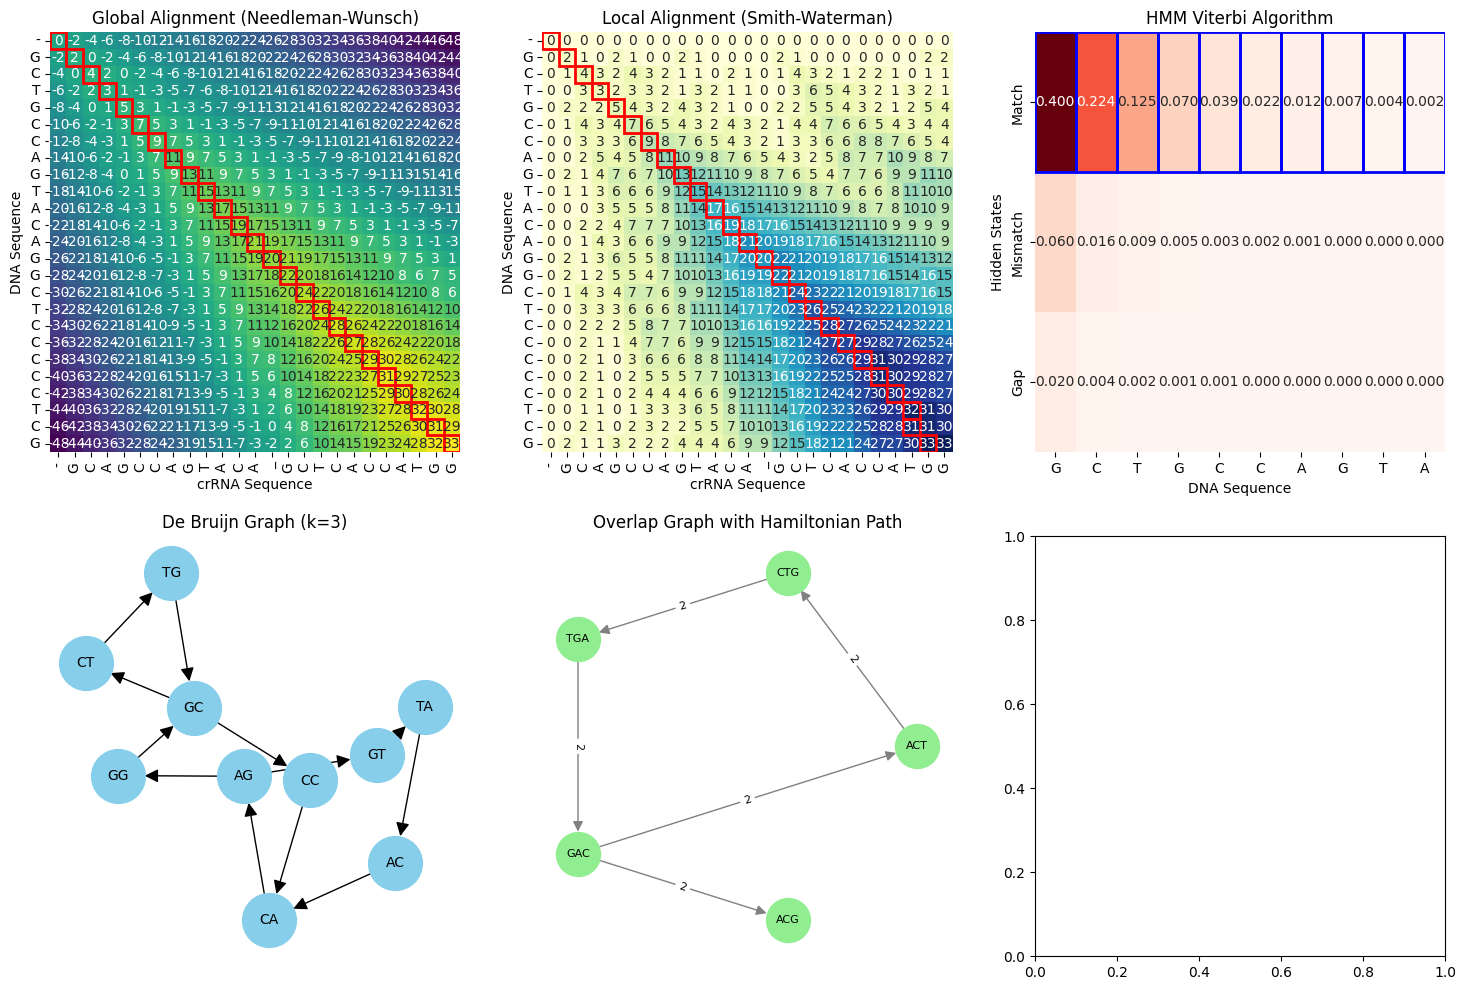

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
from matplotlib.animation import FuncAnimation
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import io
import base64
from IPython.display import HTML

# Load the data from CSV files
def load_data():
    try:
        # Load GUIDE_seq.csv
        guide_data = pd.read_csv('Indel\GUIDE-Seq.csv')
        
        # Load CIRCLE_seq.csv
        circle_data = pd.read_csv('Indel\CIRCLE_seq.csv')
        
        return guide_data, circle_data
    except FileNotFoundError:
        print("Error: One or both CSV files not found. Using sample data instead.")
        
        # Create sample guide data
        guide_sample = pd.DataFrame({
            'DNA': ['GCTGCCAGTACAGGCTCCCCCTCG'],
            'crRNA': ['GCAGCCAGTACA_GCTCACCATGG'],
            'label': [0.0],
            'read': [0.0],
            'pair': ['GCAGCCAGTACA_GCTCACCATGG|GCTGCCAGTACAGGCTCCCCCTCG']
        })
        
        # Create sample circle data
        circle_sample = pd.DataFrame({
            'sgRNA_seq': ['G_AGTCCGAGCAGAAGAAGAAAGG'],
            'off_seq': ['GGAGTCCGTGCAGAAGCAGGAAGC'],
            'label': [0.0],
            'Read': [0.0],
            'sgRNA_type': ['GAGTCCGAGCAGAAGAAGAANGG'],
            'Cell': [''],
            'Read_normalised': [0.0]
        })
        
        return guide_sample, circle_sample

# Load the data
guide_data, circle_data = load_data()

# Preprocess sequence data
def preprocess_sequences(data, seq_col1, seq_col2, max_samples=5):
    # Take the first few samples
    data = data.head(max_samples).copy()
    
    # Clean sequences (replace '_' with '-' for alignment)
    data[seq_col1] = data[seq_col1].str.replace('_', '-')
    data[seq_col2] = data[seq_col2].str.replace('_', '-')
    
    return data

# For GUIDE_seq data
guide_processed = preprocess_sequences(guide_data, 'DNA', 'crRNA')

# For CIRCLE_seq data
if 'DNA' in circle_data.columns and 'crRNA' in circle_data.columns:
    circle_processed = preprocess_sequences(circle_data, 'DNA', 'crRNA')
else:
    # Assuming the first column is DNA and second is crRNA
    col_names = circle_data.columns.tolist()
    circle_processed = preprocess_sequences(circle_data, col_names[0], col_names[1])
    col_names[0], col_names[1] = 'DNA', 'crRNA'
    circle_processed.columns = col_names

# Global Sequence Alignment Implementation
def global_alignment_matrix(seq1, seq2):
    # Scoring parameters
    match = 2
    mismatch = -1
    gap = -2
    
    # Initialize the matrix
    n, m = len(seq1), len(seq2)
    score_matrix = np.zeros((n+1, m+1))
    traceback = np.zeros((n+1, m+1), dtype=int)  # 0: diag, 1: up, 2: left
    
    # Initialize first row and column with gap penalties
    for i in range(n+1):
        score_matrix[i, 0] = i * gap
        if i > 0:
            traceback[i, 0] = 1
    for j in range(m+1):
        score_matrix[0, j] = j * gap
        if j > 0:
            traceback[0, j] = 2
    
    # Fill the matrix
    for i in range(1, n+1):
        for j in range(1, m+1):
            if seq1[i-1] == seq2[j-1]:
                match_score = match
            else:
                match_score = mismatch
            
            diag = score_matrix[i-1, j-1] + match_score
            up = score_matrix[i-1, j] + gap
            left = score_matrix[i, j-1] + gap
            
            if diag >= up and diag >= left:
                score_matrix[i, j] = diag
                traceback[i, j] = 0
            elif up >= diag and up >= left:
                score_matrix[i, j] = up
                traceback[i, j] = 1
            else:
                score_matrix[i, j] = left
                traceback[i, j] = 2
    
    return score_matrix, traceback

def get_alignment_path(traceback):
    i, j = traceback.shape[0]-1, traceback.shape[1]-1
    path = [(i, j)]
    
    while i > 0 or j > 0:
        if traceback[i, j] == 0:  # diagonal
            i -= 1
            j -= 1
        elif traceback[i, j] == 1:  # up
            i -= 1
        else:  # left
            j -= 1
        path.append((i, j))
    
    return path[::-1]  # Reverse to get path from start to end

# Local Sequence Alignment Implementation
def local_alignment_matrix(seq1, seq2):
    # Scoring parameters
    match = 2
    mismatch = -1
    gap = -1
    
    # Initialize the matrix
    n, m = len(seq1), len(seq2)
    score_matrix = np.zeros((n+1, m+1))
    traceback = np.zeros((n+1, m+1), dtype=int)  # 0: end, 1: diag, 2: up, 3: left
    
    # Fill the matrix
    max_score = 0
    max_pos = (0, 0)
    
    for i in range(1, n+1):
        for j in range(1, m+1):
            if seq1[i-1] == seq2[j-1]:
                match_score = match
            else:
                match_score = mismatch
            
            diag = score_matrix[i-1, j-1] + match_score
            up = score_matrix[i-1, j] + gap
            left = score_matrix[i, j-1] + gap
            
            score_matrix[i, j] = max(0, diag, up, left)
            
            if score_matrix[i, j] == 0:
                traceback[i, j] = 0
            elif score_matrix[i, j] == diag:
                traceback[i, j] = 1
            elif score_matrix[i, j] == up:
                traceback[i, j] = 2
            else:
                traceback[i, j] = 3
                
            if score_matrix[i, j] > max_score:
                max_score = score_matrix[i, j]
                max_pos = (i, j)
    
    return score_matrix, traceback, max_pos

def get_local_alignment_path(traceback, max_pos):
    i, j = max_pos
    path = [(i, j)]
    
    while traceback[i, j] != 0:
        if traceback[i, j] == 1:  # diagonal
            i -= 1
            j -= 1
        elif traceback[i, j] == 2:  # up
            i -= 1
        else:  # left
            j -= 1
        path.append((i, j))
        
        if i == 0 or j == 0:
            break
    
    return path[::-1]  # Reverse to get path from start to end

# HMM Viterbi Algorithm Implementation
def hmm_viterbi_step_by_step(observation, states=['Match', 'Mismatch', 'Gap']):
    # Simplified HMM for sequence alignment
    # Initial probabilities
    start_prob = {'Match': 0.5, 'Mismatch': 0.3, 'Gap': 0.2}
    
    # Transition probabilities
    trans_prob = {
        'Match': {'Match': 0.7, 'Mismatch': 0.2, 'Gap': 0.1},
        'Mismatch': {'Match': 0.4, 'Mismatch': 0.4, 'Gap': 0.2},
        'Gap': {'Match': 0.4, 'Mismatch': 0.3, 'Gap': 0.3}
    }
    
    # Emission probabilities
    emit_prob = {
        'Match': {'A': 0.8, 'C': 0.8, 'G': 0.8, 'T': 0.8, '-': 0.1},
        'Mismatch': {'A': 0.2, 'C': 0.2, 'G': 0.2, 'T': 0.2, '-': 0.2},
        'Gap': {'A': 0.1, 'C': 0.1, 'G': 0.1, 'T': 0.1, '-': 0.9}
    }
    
    # Initialize the Viterbi matrix
    V = np.zeros((len(states), len(observation)))
    backpointer = np.zeros((len(states), len(observation)), dtype=int)
    
    # Initialize the first column
    for i, state in enumerate(states):
        V[i, 0] = start_prob[state] * emit_prob[state].get(observation[0], 0.01)
    
    # Generate step by step matrices
    matrices = [V.copy()]
    
    # Fill the rest of the matrix
    for t in range(1, len(observation)):
        for i, state in enumerate(states):
            max_prob = 0
            max_state = 0
            for j, prev_state in enumerate(states):
                prob = V[j, t-1] * trans_prob[prev_state][state] * emit_prob[state].get(observation[t], 0.01)
                if prob > max_prob:
                    max_prob = prob
                    max_state = j
            V[i, t] = max_prob
            backpointer[i, t] = max_state
        matrices.append(V.copy())
    
    # Find the best path
    best_path_prob = np.max(V[:, -1])
    best_state = np.argmax(V[:, -1])
    
    # Traceback
    path = [best_state]
    for t in range(len(observation)-1, 0, -1):
        best_state = backpointer[best_state, t]
        path.append(best_state)
    
    path = path[::-1]  # Reverse to get path from start to end
    
    return matrices, path, states

# De Bruijn Graph Animation
def build_debruijn_graph(sequence, k=3):
    G = nx.DiGraph()
    
    if len(sequence) < k:
        return G
    
    # Create edges from k-1 mers to their overlapping k-1 mers
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i+k]
        prefix = kmer[:-1]
        suffix = kmer[1:]
        G.add_edge(prefix, suffix)
    
    return G

def build_debruijn_graph_step_by_step(sequence, k=3):
    graphs = []
    G = nx.DiGraph()
    
    if len(sequence) < k:
        return [G]
    
    # Create edges step by step
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i+k]
        prefix = kmer[:-1]
        suffix = kmer[1:]
        G.add_edge(prefix, suffix, label=kmer)
        graphs.append(G.copy())
    
    return graphs

# Overlap Graph and Assembly Animation
def build_overlap_graph_step_by_step(sequences, min_overlap=2):
    graphs = []
    G = nx.DiGraph()
    
    # Add nodes
    for seq in sequences:
        G.add_node(seq)
    graphs.append(G.copy())
    
    # Add edges step by step
    for i, seq1 in enumerate(sequences):
        for j, seq2 in enumerate(sequences):
            if i != j:
                # Find maximum overlap
                max_overlap = 0
                for overlap in range(min_overlap, min(len(seq1), len(seq2)) + 1):
                    if seq1[-overlap:] == seq2[:overlap]:
                        max_overlap = overlap
                
                if max_overlap >= min_overlap:
                    G.add_edge(seq1, seq2, weight=max_overlap, label=f"{max_overlap}")
                    graphs.append(G.copy())
    
    return graphs

# Create separate animations for each algorithm
def create_animations():
    # Choose sequences for visualization
    seq1 = guide_data['DNA'].iloc[0]
    seq2 = guide_data['crRNA'].iloc[0]
    
    # Calculate matrices for animations
    global_matrix, global_traceback = global_alignment_matrix(seq1, seq2)
    global_path = get_alignment_path(global_traceback)
    
    local_matrix, local_traceback, max_pos = local_alignment_matrix(seq1, seq2)
    local_path = get_local_alignment_path(local_traceback, max_pos)
    
    viterbi_matrices, viterbi_path, states = hmm_viterbi_step_by_step(seq1[:10])
    
    debruijn_graphs = build_debruijn_graph_step_by_step(seq1.replace('-', '')[:15], k=3)
    
    small_seqs = ["ACT", "CTG", "TGA", "GAC", "ACG"]
    overlap_graphs = build_overlap_graph_step_by_step(small_seqs, min_overlap=2)

    # Create Global Alignment Animation
    def create_global_animation():
        fig, ax = plt.subplots(figsize=(8, 6))
        def animate(frame):
            ax.clear()
            path_idx = min(frame, len(global_path)-1)
            highlighted_cells = global_path[:path_idx+1]
            sns.heatmap(global_matrix, annot=True, fmt=".0f", cmap="viridis", cbar=False, ax=ax)
            for i, j in highlighted_cells:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=2))
            ax.set_title("Global Alignment (Needleman-Wunsch)")
            ax.set_xlabel("crRNA Sequence")
            ax.set_ylabel("DNA Sequence")
            ax.set_xticklabels(['-'] + list(seq2))
            ax.set_yticklabels(['-'] + list(seq1))
        anim = FuncAnimation(fig, animate, frames=len(global_path), interval=500)
        anim.save('output/vis/global_alignment.gif', writer='pillow', fps=2)
        plt.close()

    # Create Local Alignment Animation
    def create_local_animation():
        fig, ax = plt.subplots(figsize=(8, 6))
        def animate(frame):
            ax.clear()
            path_idx = min(frame, len(local_path)-1)
            highlighted_cells = local_path[:path_idx+1]
            sns.heatmap(local_matrix, annot=True, fmt=".0f", cmap="YlGnBu", cbar=False, ax=ax)
            for i, j in highlighted_cells:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=2))
            ax.set_title("Local Alignment (Smith-Waterman)")
            ax.set_xlabel("crRNA Sequence")
            ax.set_ylabel("DNA Sequence")
            ax.set_xticklabels(['-'] + list(seq2))
            ax.set_yticklabels(['-'] + list(seq1))
        anim = FuncAnimation(fig, animate, frames=len(local_path), interval=500)
        anim.save('output/vis/local_alignment.gif', writer='pillow', fps=2)
        plt.close()

    # Create HMM Viterbi Animation
    def create_viterbi_animation():
        fig, ax = plt.subplots(figsize=(8, 6))
        def animate(frame):
            ax.clear()
            current_matrix = viterbi_matrices[min(frame, len(viterbi_matrices)-1)]
            sns.heatmap(current_matrix, annot=True, fmt=".3f", cmap="Reds", cbar=False, ax=ax)
            if frame > 0 and frame < len(viterbi_path):
                for t in range(frame):
                    state_idx = viterbi_path[t]
                    ax.add_patch(plt.Rectangle((t, state_idx), 1, 1, fill=False, edgecolor='blue', lw=2))
            ax.set_title("HMM Viterbi Algorithm")
            ax.set_xlabel("DNA Sequence")
            ax.set_ylabel("Hidden States")
            ax.set_xticklabels(list(seq1[:10]))
            ax.set_yticklabels(states)
        anim = FuncAnimation(fig, animate, frames=len(viterbi_matrices), interval=500)
        anim.save('output/vis/viterbi.gif', writer='pillow', fps=2)
        plt.close()

    # Create De Bruijn Graph Animation
    def create_debruijn_animation():
        fig, ax = plt.subplots(figsize=(8, 6))
        def animate(frame):
            ax.clear()
            G = debruijn_graphs[min(frame, len(debruijn_graphs)-1)]
            if len(G.nodes()) > 0:
                pos = nx.spring_layout(G, seed=42)
                nx.draw(G, pos, with_labels=True, node_color='skyblue',
                       node_size=1500, edge_color='black', arrowsize=20,
                       font_size=10, ax=ax)
                edge_labels = {(u, v): d.get('label', '') for u, v, d in G.edges(data=True)}
                nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
            ax.set_title(f"De Bruijn Graph Construction")
            ax.axis('off')
        anim = FuncAnimation(fig, animate, frames=len(debruijn_graphs), interval=500)
        anim.save('output/vis/debruijn.gif', writer='pillow', fps=2)
        plt.close()

    # Create Overlap Graph Animation
    def create_overlap_animation():
        fig, ax = plt.subplots(figsize=(8, 6))
        def animate(frame):
            ax.clear()
            G = overlap_graphs[min(frame, len(overlap_graphs)-1)]
            if len(G.nodes()) > 0:
                pos = nx.circular_layout(G)
                nx.draw(G, pos, with_labels=True, node_color='lightgreen',
                       node_size=1000, edge_color='gray', arrowsize=15,
                       font_size=8, ax=ax)
                edge_labels = {(u, v): d.get('label', '') for u, v, d in G.edges(data=True)}
                nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
            ax.set_title(f"Overlap Graph Construction")
            ax.axis('off')
        anim = FuncAnimation(fig, animate, frames=len(overlap_graphs), interval=500)
        anim.save('output/vis/overlap.gif', writer='pillow', fps=2)
        plt.close()

    # Create all animations
    print("Creating animations...")
    create_global_animation()
    print("Global alignment animation saved as 'global_alignment.gif'")
    create_local_animation()
    print("Local alignment animation saved as 'local_alignment.gif'")
    create_viterbi_animation()
    print("Viterbi animation saved as 'viterbi.gif'")
    create_debruijn_animation()
    print("De Bruijn graph animation saved as 'debruijn.gif'")
    create_overlap_animation()
    print("Overlap graph animation saved as 'overlap.gif'")

# Call the new animation creation function
create_animations()

# Also create a static figure for reference
def create_static_figures():
    # Use the first pair of sequences
    seq1 = guide_data['DNA'].iloc[0]
    seq2 = guide_data['crRNA'].iloc[0]
    
    # Setup the figure
    fig = plt.figure(figsize=(18, 12))
    
    # 1. Global Alignment
    ax1 = plt.subplot(2, 3, 1)
    global_matrix, global_traceback = global_alignment_matrix(seq1, seq2)
    global_path = get_alignment_path(global_traceback)
    
    sns.heatmap(global_matrix, annot=True, fmt=".0f", cmap="viridis", cbar=False, ax=ax1)
    
    # Highlight the optimal path
    for i, j in global_path:
        ax1.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=2))
    
    ax1.set_title("Global Alignment (Needleman-Wunsch)")
    ax1.set_xlabel("crRNA Sequence")
    ax1.set_ylabel("DNA Sequence")
    ax1.set_xticklabels(['-'] + list(seq2))
    ax1.set_yticklabels(['-'] + list(seq1))
    
    # 2. Local Alignment
    ax2 = plt.subplot(2, 3, 2)
    local_matrix, local_traceback, max_pos = local_alignment_matrix(seq1, seq2)
    local_path = get_local_alignment_path(local_traceback, max_pos)
    
    sns.heatmap(local_matrix, annot=True, fmt=".0f", cmap="YlGnBu", cbar=False, ax=ax2)
    
    # Highlight the optimal path
    for i, j in local_path:
        ax2.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=2))
    
    ax2.set_title("Local Alignment (Smith-Waterman)")
    ax2.set_xlabel("crRNA Sequence")
    ax2.set_ylabel("DNA Sequence")
    ax2.set_xticklabels(['-'] + list(seq2))
    ax2.set_yticklabels(['-'] + list(seq1))
    
    # 3. HMM Viterbi
    ax3 = plt.subplot(2, 3, 3)
    viterbi_matrices, viterbi_path, states = hmm_viterbi_step_by_step(seq1[:10])
    
    sns.heatmap(viterbi_matrices[-1], annot=True, fmt=".3f", cmap="Reds", cbar=False, ax=ax3)
    
    # Highlight the optimal path
    for t, state_idx in enumerate(viterbi_path):
        ax3.add_patch(plt.Rectangle((t, state_idx), 1, 1, fill=False, edgecolor='blue', lw=2))
    
    ax3.set_title("HMM Viterbi Algorithm")
    ax3.set_xlabel("DNA Sequence")
    ax3.set_ylabel("Hidden States")
    ax3.set_xticklabels(list(seq1[:10]))
    ax3.set_yticklabels(states)
    
    # 4. De Bruijn Graph
    ax4 = plt.subplot(2, 3, 4)
    G_debruijn = build_debruijn_graph(seq1.replace('-', '')[:15], k=3)
    
    if len(G_debruijn.nodes()) > 0:
        pos = nx.spring_layout(G_debruijn, seed=42)
        nx.draw(G_debruijn, pos, with_labels=True, node_color='skyblue', 
               node_size=1500, edge_color='black', arrowsize=20, 
               font_size=10, ax=ax4)
    
    ax4.set_title("De Bruijn Graph (k=3)")
    ax4.axis('off')
    
    # 5. Overlap Graph
    ax5 = plt.subplot(2, 3, 5)
    small_seqs = ["ACT", "CTG", "TGA", "GAC", "ACG"]
    G_overlap = nx.DiGraph()
    
    # Add nodes
    for seq in small_seqs:
        G_overlap.add_node(seq)
    
    # Add edges
    for i, seq1 in enumerate(small_seqs):
        for j, seq2 in enumerate(small_seqs):
            if i != j:
                # Find maximum overlap
                max_overlap = 0
                for overlap in range(2, min(len(seq1), len(seq2)) + 1):
                    if seq1[-overlap:] == seq2[:overlap]:
                        max_overlap = overlap
                
                if max_overlap >= 2:
                    G_overlap.add_edge(seq1, seq2, weight=max_overlap)
    
    pos = nx.circular_layout(G_overlap)
    nx.draw(G_overlap, pos, with_labels=True, node_color='lightgreen', 
           node_size=1000, edge_color='gray', arrowsize=15, 
           font_size=8, ax=ax5)
    
    # Add edge labels showing overlap weights
    edge_labels = {(u, v): d['weight'] for u, v, d in G_overlap.edges(data=True)}
    nx.draw_networkx_edge_labels(G_overlap, pos, edge_labels=edge_labels, font_size=8, ax=ax5)
    
    ax5.set_title("Overlap Graph with Hamiltonian Path")
    ax5.axis('off')
    
    # 6. Sequence Alignment Visualization
    ax6 = plt.subplot(2, 3, 6)
    
    # Get sequences from the alignment
    aligned_seq1 = []
    aligned_seq2 = []
    i, j = 0, 0
    
    for idx, (row, col) in enumerate(global_path[1:]):  # Skip the first (0,0) element
        prev_row, prev_col = global_path[idx]
        
        if row > prev_row and col > prev_col:  # Diagonal move
            aligned_seq1.append(seq1[row-1])
            aligned_seq2.append(seq2[col-1])
        elif row > prev_row:  # Vertical move (gap in seq2)
            aligned_seq1.append(seq1[row-1])
            aligned_seq2.append('-')
        else:  # Horizontal move (gap in seq1)
            aligned_seq1.append('-')
            aligned_seq2.append(seq2[col-1])
    
    # Visualize the alignment
    alignment_text = [
        "DNA:   " + ''.join(aligned_seq1),
        "       " + ''.join('|' if c1 == c2 and c1 != '-' else ' ' 
                           for c1, c2 in zip(aligned_seq1, aligned_seq2)),
        "crRNA: " + ''.join(aligned_seq2)
    ]
    
    ax6.text(0.5, 0.5, '\n'.join(alignment_text), fontsize=10, 
            family='monospace', ha='center', va='center')
    
    ax6.set_title("Sequence Alignment Result")
    ax6.axis('off')
    
    plt.tight_layout()
    plt.savefig('bioinformatics_summary.png', dpi=300)
    plt.close()

# Create static figures
create_static_figures()
print("Static figure saved as 'bioinformatics_summary.png'")